In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# First load in RRR counts

In [37]:
rrr_file = '/home/oliverphilcox/3pcf_code/codes/grid_multipoles/rrr-qpm-counts-new'

In [78]:
n_bins = 18
n_mult = 10

import re,string

start=False
RRR_mult=np.zeros([n_bins,n_bins,n_mult+1])
            
with open(rrr_file,"r") as xi_in:
    for line in xi_in:
        if not start:
            if(re.match("# Multipole power",line)):
                start=True
                continue
        if(re.match("# Total",line)):
            start=False
            continue
        if start:
            if(re.match("Multipole",line)):
                continue
            strip_line = line.strip()
            if len(strip_line)==0:
                continue
            split_line=strip_line.split()
            r1 = int(split_line[0])
            r2 = int(split_line[1])
            for i in range(n_mult+1):
                RRR_mult[r1,r2,i]=split_line[int(i+2)]
                if i>0:
                    RRR_mult[r1,r2,i]*=RRR_mult[r1,r2,0]
                RRR_mult[r2,r1,i]=RRR_mult[r1,r2,i]

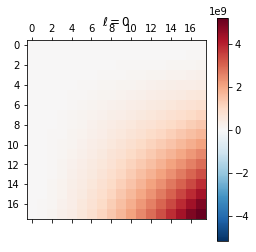

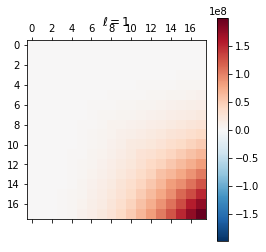

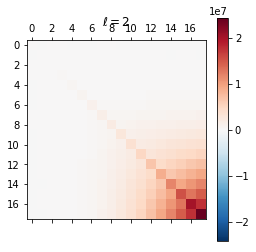

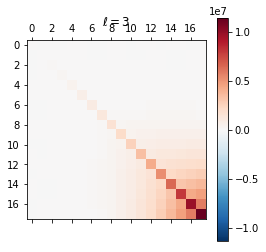

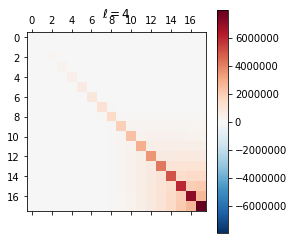

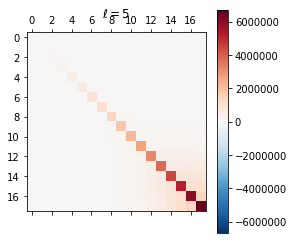

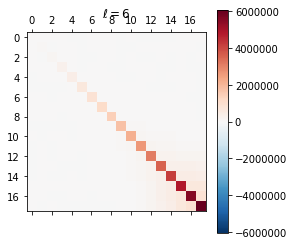

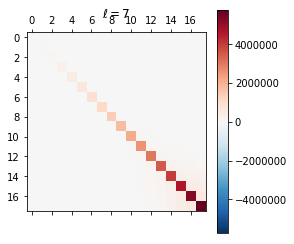

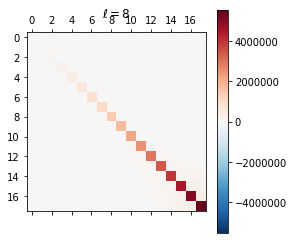

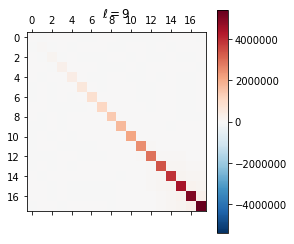

In [79]:
r_bins = np.linspace(5,175,n_bins)
for ell in range(10):
    mat=RRR_mult[:,:,ell]
    vmax=np.percentile(mat.ravel(),99.9)
    plt.matshow(RRR_mult[:,:,ell],cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    plt.colorbar();
    plt.title(r'$\ell = %d$'%ell)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend();

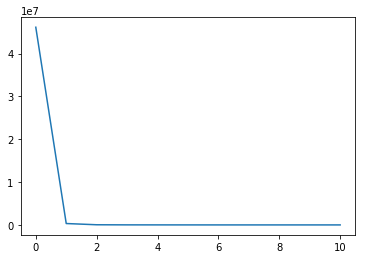

In [80]:
plt.plot(RRR_mult[4,5])


### Construct Survey Correction Function

This is done for a single QPM mock here

Define correction factor as:
$\Phi(r_a,r_b,\chi_c) = \frac{3V \overline{(nw)^3}v_av_b\delta \chi}{RRR_{ab}^c}$
in angular bin $c$, radial bin $a,b$ for $v_a = 4\pi(r_{a,\mathrm{max}}^3-r_{a,\mathrm{min}}^3)/3$

#### Load in galaxy data-set to estimate $\bar n$, $\bar w$ and $V$.

In [81]:
gal_file = '/mnt/store1/oliverphilcox/PowerSpectra/qpm_galaxy_1.xyzwj'
all_gal = np.loadtxt(gal_file)

In [82]:
gal_x = all_gal[:,0]
gal_y = all_gal[:,1]
gal_z = all_gal[:,2]
gal_w = all_gal[:,3]
gal_n = (1./gal_w-1.)/20000

In [83]:
N_gal = len(all_gal)
w_bar = mean(gal_w)

In [84]:
nw_3_mean = np.mean((gal_n*gal_w)**3)

Find volume via ConvexHull

In [85]:
import scipy.spatial as ss
hull = ss.ConvexHull(np.vstack([gal_x,gal_y,gal_z]).T)
print('volume inside points is: ',hull.volume)
V=hull.volume # in (Mpc/h)^3

volume inside points is:  4039684687.8916426


#### Survey normalization

In [86]:
norm = 6*V*nw_3_mean
print(norm)

0.001796604701715402


In [87]:
np.save('/mnt/store1/oliverphilcox/3PCF/Normalization2.npy',norm)

#### Load a random catalog

In [88]:
rand_file = '/mnt/store1/oliverphilcox/3PCF_QPM/QPM/qpm.ran.00'
N_rand = len(np.loadtxt(rand_file))

In [89]:
N_rand

963076

In [90]:
ells = np.arange(len(RRR_mult[0,0]))

In [91]:
N_gal_ratio = N_gal/N_rand # ratio of galaxies to randoms
RRR_mult_normed=RRR_mult*N_gal_ratio**3*6 # 6 is difference between DJE and our normalizations (i.e. we count 6 perms)

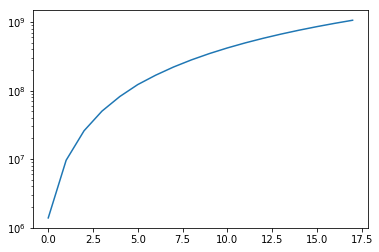

In [104]:
plt.plot(RRR_mult_normed[:,5,0])
plt.yscale('log')

In [92]:
r_lo = np.linspace(0,170,18)
r_hi = np.linspace(10,180,18)

phi_inv_mult = np.zeros([n_bins,n_bins,len(ells)])
for b1 in range(len(r_lo)):
    for b2 in range(len(r_hi)):
        v1 = 4.*np.pi/3*(r_hi[b1]**3-r_lo[b1]**3)
        v2 = 4.*np.pi/3*(r_hi[b2]**3-r_lo[b2]**3)

        this_RRR_mult = RRR_mult_normed[b1,b2]

        phi_inv_mult[b1,b2,:] = this_RRR_mult/(3*V*nw_3_mean*v1*v2)

In [93]:
norm

0.001796604701715402

In [112]:
outfile = '/mnt/store1/oliverphilcox/3PCF/ReNormedBinCorrectionFactor_n15_11.txt'
with open(outfile,"w") as outt:
    for b1 in range(len(r_lo)):
        if r_lo[b1]<30:
            continue
        for b2 in range(len(r_lo)):
            if r_lo[b2]<30:
                continue
            for ell in ells:
                if ell<7:
                    outt.write("%.8e"%(phi_inv_mult[b1,b2,ell]*norm))
                if ell<6:
                    outt.write("\t")
                if ell==6:
                    outt.write("\n")
        #if b2<len(r_lo)-1:
        #    outt.write("\n")

In [113]:
d=np.loadtxt('/mnt/store1/oliverphilcox/3PCF/Normed2BinCorrectionFactor_n15_11.txt')
d2=np.loadtxt('/mnt/store1/oliverphilcox/3PCF/ReNormedBinCorrectionFactor_n15_11.txt')

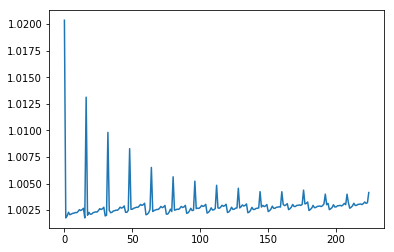

In [114]:
plt.plot(d2[:,0]/d[:,0])

In [111]:
d.shape

(225, 7)

In [470]:
ratios=[]
ct=0
for b1 in range(len(r_lo)):
    for b2 in range(len(r_lo)):
        if b1!=b2:
            ratios.append((phi_inv_mult[b1,b2,:]/phi_inv_mult[b1,b2,0]))
            ct+=1
ratios=np.asarray(ratios)

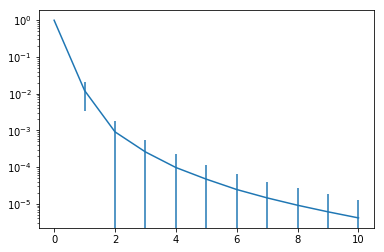

In [473]:
plt.errorbar(ells,np.mean(ratios,axis=0),np.std(ratios,axis=0))
plt.yscale('log')

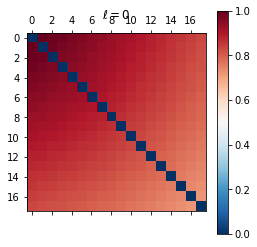

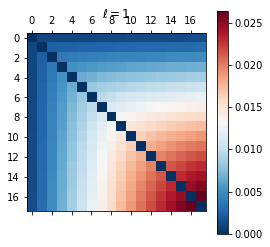

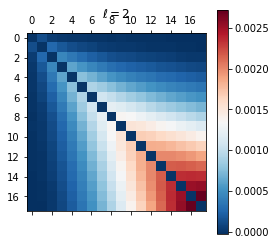

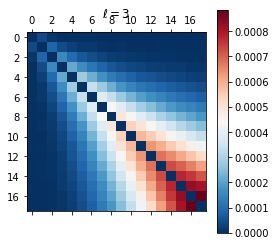

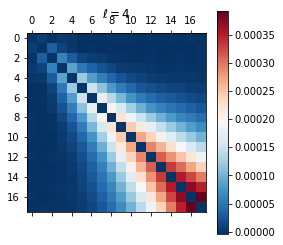

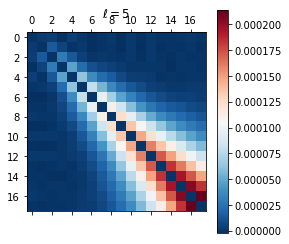

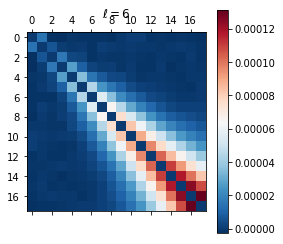

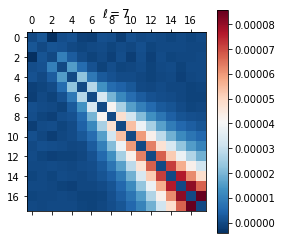

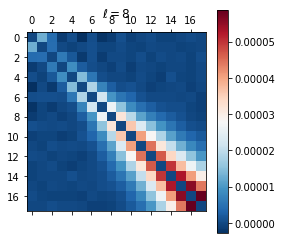

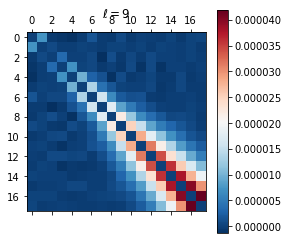

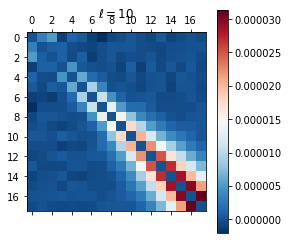

In [448]:
for ell in ells:
    mat=phi_inv_mult[:,:,ell]-np.diag(phi_inv_mult[:,:,ell])*np.eye(n_bins)
    #vmax=1.
    plt.matshow(mat,cmap=cm.RdBu_r)#vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.colorbar();
    plt.title(r'$\ell = %d$'%ell)

In [449]:
r_lo = np.linspace(0,170,18)
r_hi = np.linspace(10,180,18)

b1=12
b2=6

v1 = 4.*np.pi/3*(r_hi[b1]**3-r_lo[b1]**3)
v2 = 4.*np.pi/3*(r_hi[b2]**3-r_lo[b2]**3)

mu_arr = np.linspace(-1.,1.,1000)

diff_mu = mu_arr[1]-mu_arr[0]

from scipy.special import legendre
ells = np.arange(len(this_RRR_mult))
this_RRR_mult = RRR_mult[b1,b2]

this_RRR_mu = np.zeros_like(mu_arr)
for ell in ells:
    leg = legendre(ell)(mu_arr)
    this_RRR_mu+=leg*this_RRR_mult[ell]
    
phi_true = 6*V*nw_3_mean*v1*v2/this_RRR_mu
    
def phi_model(mu,*par):
    g1,g2,g3,g4=par
    return g1+g2*mu+g3*mu**2+g4*mu**3

from scipy.optimize import minimize
out=minimize(lambda par: np.sum((phi_model(mu_arr,*par)-phi_true)**2),[1.,0.,0.,0.])
out_par = out.x

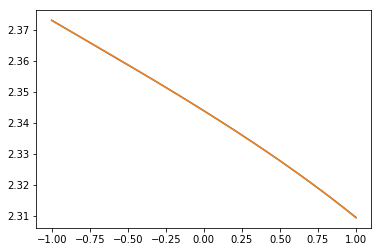

In [450]:
plt.plot(mu_arr,phi_model(mu_arr,*out_par))
plt.plot(mu_arr,phi_true)

In [451]:
phi_model(0.1,*out_par)

2.340805653961206

In [452]:
v1

1964542.6060448173

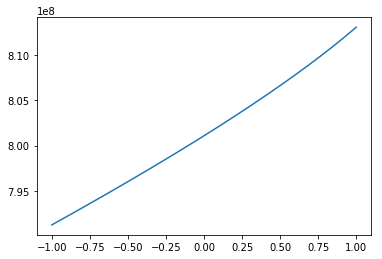

In [453]:
plt.plot(mu_arr,this_RRR_mu)

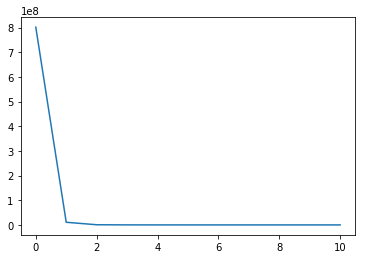

In [454]:
plt.plot(this_RRR_mult)

### Make some sample data for testing

In [393]:
N_rand=50
rands = np.random.uniform(0,1,size=(N_rand,3))
ws = np.ones([N_rand,1])
rands=np.hstack([rands,ws])

In [394]:
np.savetxt('rands_test.txt',rands)

In [419]:
bbins = 1
rrmax = 0.5
rrmax2 = rrmax**2
triples=0
pairs=0
def dis(vec):
    return np.sqrt(vec[0]**2.+vec[1]**2.+vec[2]**2.)

def dis2(vec):
    return vec[0]**2.+vec[1]**2.+vec[2]**2.


for i in range(N_rand):
    for j in range(N_rand):
        if j==i:
            continue
        for k in range(N_rand):
            if j==k:
                continue
            if k==i:
                continue
            diff_ij = rands[i]-rands[j]
            diff_ik = rands[i]-rands[k]
            diff_jk = rands[j]-rands[k]
            dis_ij = dis(diff_ij)
            dis_jk = dis(diff_jk)
            dis_ik = dis(diff_ik)
            
            all_dis = np.array([dis_ij,dis_jk,dis_ik])
            p=np.sum((all_dis<0.5)&(all_dis>0.25))
            q=np.sum((all_dis>1e-6)&(all_dis<0.25))
            
            if((dis_ij<0.5)&(dis_ij>0.25)):
                if((dis_ik<0.25)):
                    triples+=1
            
            #if p==1:
            #    if q==1:
            #        triples+=1
#             if dis_ij<0.5:
#                 if dis_jk<0.5:
#                     triples+=1
#                 if dis_ik<0.5:
#                     triples+=1
#             if dis_ik<0.5:
#                 if dis_ij<0.5:
#                     triples+=1
#                 if dis_jk<0.5:
#                     triples+=1
#             if dis_jk<0.5:
#                 if dis_ij<0.5:
#                     triples+=1
#                 if dis_jk<0.5:
#                     triples+=1
                    
for i in range(N_rand):
    for j in range(N_rand):
        if i==j:
            continue
        diff_ij = rands[i]-rands[j]
        dis_ij = dis2(diff_ij)
        if dis_ij<=rrmax2 and dis_ij>1e-12*rrmax2:
            pairs+=1

In [420]:
triples,pairs

(1849, 716)

In [421]:
triples/1849

1.0

#### Define bin widths and central radii

In [436]:
m = 1000

In [437]:
mu_cen = np.arange(1/(2*m),1+1/(2*m),1/m)

In [441]:
r_bins = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/radial_binning_cov.csv')
r_cen = mean(r_bins,axis=1)
delta_r = r_cen[-1]-r_cen[-2]
mu_cen = np.arange(1/(2*m),1.+1/(2*m),1/m)
delta_mu = mu_cen[-1]-mu_cen[-2]
n=len(r_cen)
m=len(mu_cen)

#### Load in data

In [442]:
RR_file = '/mnt/store1/oliverphilcox/Legendre2PCF/RR_n35_m1000.txt'
RR_flat = np.loadtxt(RR_file)*np.sum(gal_w)**2.# must remove normalization factor

In [445]:
RR_true = RR_flat.reshape((n,m))

#### Define RR model

In [446]:
def RR_model(r_cen,mu):
    return 4.*np.pi*V*(n_bar*w_bar)**2.*r_cen**2.*delta_r*delta_mu

In [447]:
all_ratios = [RR_true[:,i]/RR_model(r_cen,mu_cen[i]) for i in range(m)]
if np.mean(all_ratios)>10:
    raise Exception("RR_true seems to be much larger than RR_model. Is the input RR correctly normalized?")
if np.mean(all_ratios)<0.1:
    raise Exception("RR_true seems to be much larger than RR_model. Is the input RR correctly normalized?")

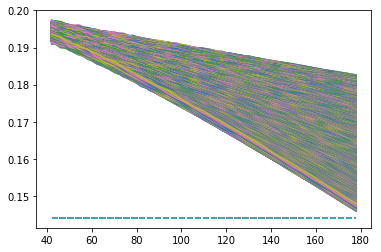

In [448]:
for i in range(m):
    plt.plot(r_cen,RR_true[:,i]/r_cen**2,ls='-')
    plt.plot(r_cen,RR_model(r_cen,mu_cen[i])/r_cen**2.,ls='--')

#### Find $\Phi$ functions

In [449]:
Phi_values = []
for r_bin in range(n):
    Phi_values.append(RR_model(r_cen[r_bin],mu_cen)/RR_true[r_bin,:])
    

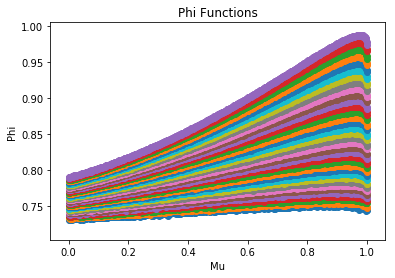

In [450]:
for i in range(n):
    plt.scatter(mu_cen,Phi_values[i]);
plt.title('Phi Functions')
plt.ylabel('Phi');plt.xlabel('Mu');

#### Fit to smooth function

Pick the piecewise continuous function;
$$\Phi(r_a,\mu) = \begin{cases} a_0+a_1\mu & \text{ if }\mu<0.75\\ b_0+b_1\mu+b_2\mu^2+b_3\mu^3 & \text{ if }\mu \geq 0.75\end{cases}$$
with $b_0$ and $b_1$ set by imposing that $\Phi$ and $d\Phi/d\mu$ are continuous at $\mu=0.75$.

In [462]:
mu_crit=0.75

In [463]:
def Phi_model(mu,a0,a1,a2,b2,b3,mu_crit=mu_crit):
    b1=a1+2*mu_crit*(a2-b2)-3*b3*mu_crit**2.
    b0=a0+(a1-b1)*mu_crit+(a2-b2)*mu_crit**2.-b3*mu_crit**3.
    filt1=np.where(mu<mu_crit)
    filt2=np.where(mu>=mu_crit)
    output=np.zeros_like(mu)
    output[filt1]=a0+a1*mu[filt1]+a2*mu[filt1]**2.
    output[filt2]=b0+b1*mu[filt2]+b2*mu[filt2]**2.+b3*mu[filt2]**3.
    return output

In [464]:
def fit_model(mu,good_param):
    return Phi_model(mu,good_param[0],good_param[1],good_param[2],good_param[3],good_param[4])

fit_params=[]
errors=[]
for i in range(n):
    good_param,_=curve_fit(Phi_model,mu_cen,Phi_values[i],p0=[0,0,0,0,0])
    a0,a1,a2,b2,b3=good_param
    b1=a1+2*mu_crit*(a2-b2)-3*b3*mu_crit**2.
    b0=a0+(a1-b1)*mu_crit+(a2-b2)*mu_crit**2.-b3*mu_crit**3.
    out_params=[a0,a1,a2,b0,b1,b2,b3]
    fit_params.append(out_params)
    errors.append(np.abs(Phi_values[i]-fit_model(mu_cen,good_param))/fit_model(mu_cen,good_param))
    

In [465]:
fit_params = np.asarray(fit_params)

Now save to file:

In [466]:
np.savetxt('/mnt/store1/oliverphilcox/Legendre2PCF/BinCorrectionFactor_n%d.txt'%n,fit_params)

### Do some graphical testing

In [467]:
test_index=20
good_param,_=curve_fit(Phi_model,mu_cen,Phi_values[test_index],p0=[0,0,0,0,0])

def fit_model(mu):
    return Phi_model(mu,good_param[0],good_param[1],good_param[2],good_param[3],good_param[4])

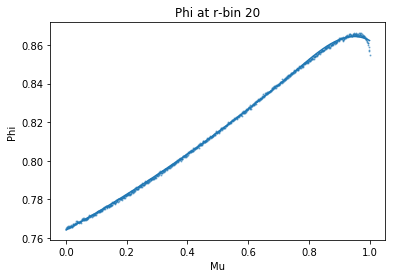

In [468]:
plt.plot(mu_cen,fit_model(mu_cen))
plt.scatter(mu_cen,Phi_values[test_index],alpha=0.5,s=1)
#plt.xlim([0.7,1])
plt.ylabel('Phi');plt.xlabel('Mu');plt.title('Phi at r-bin %d'%test_index);

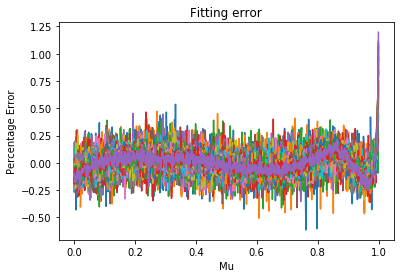

In [469]:
for i in range(n):
    good_param,_=curve_fit(Phi_model,mu_cen,Phi_values[i],p0=[0,0,0,0,0])

    def fit_model(mu):
        return Phi_model(mu,good_param[0],good_param[1],good_param[2],good_param[3],good_param[4])
    
    plt.plot(mu_cen,(fit_model(mu_cen)-Phi_values[i])/fit_model(mu_cen)*100.)
plt.title('Fitting error')
plt.xlabel('Mu')
plt.ylabel('Percentage Error');

In [470]:
d=np.loadtxt('/mnt/store1/oliverphilcox/Legendre2PCF/BinCorrectionFactor_n35_m1000.txt')